In [1]:
# !pip3 install scipy --user
# !pip3 install sklearn --user
#!pip3 install seaborn --user

# Importing Essential Libraries

In [2]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf

In [3]:
from sklearn.model_selection import train_test_split
from datetime import timedelta
import os
import time
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder


# Loading Train Data

In [4]:
train_data = scipy.io.loadmat('train_32x32.mat')
x_train = train_data['X']
y_train = train_data['y']

# Loading Test Data 

In [5]:
test_data = scipy.io.loadmat('test_32x32.mat')
x_test = test_data['X']
y_test = test_data['y']

# Shape Of Train and Test Data

In [6]:
x_train.shape

(32, 32, 3, 73257)

In [7]:
y_train.shape

(73257, 1)

In [8]:
x_test.shape

(32, 32, 3, 26032)

# Transpose Data : [width, height, channels, size] => [size, width, height, channels]

In [9]:
x_train, y_train = x_train.transpose((3,0,1,2)), y_train[:,0]
x_test, y_test = x_test.transpose((3,0,1,2)), y_test[:,0]

In [10]:
x_train.shape

(73257, 32, 32, 3)

In [11]:
y_train.shape

(73257,)

In [12]:
x_test.shape

(26032, 32, 32, 3)

In [13]:
print(np.unique(y_train))

[ 1  2  3  4  5  6  7  8  9 10]


# Split Training Data into 85:15 Train:Validation

In [14]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=7)

In [15]:
y_train.shape, y_val.shape, y_test.shape

((62268,), (10989,), (26032,))

# Convert RGB Image to Gray

In [16]:
def rgb2gray(images):
    return np.expand_dims(np.dot(images, [0.2990, 0.5870, 0.1140]), axis=3)

In [17]:
gray_train = rgb2gray(x_train).astype(np.float32)
gray_test = rgb2gray(x_test).astype(np.float32)
gray_val = rgb2gray(x_val).astype(np.float32)

# Normalization of Data

In [18]:
train_mean = np.mean(gray_train, axis=0)
train_std = np.std(gray_train, axis=0)
norm_train = (gray_train - train_mean) / train_std
norm_test = (gray_test - train_mean)  / train_std
norm_val = (gray_val - train_mean) / train_std

# One Hot Encoding for CNN classification

In [19]:
enc = OneHotEncoder().fit(y_train.reshape(-1, 1))
y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
y_test = enc.transform(y_test.reshape(-1, 1)).toarray()
y_val = enc.transform(y_val.reshape(-1, 1)).toarray()

/home/arkil/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


# Train Images in Batches

In [20]:
def get_batch(X, y, batch_size=512):
    for i in np.arange(0, y.shape[0], batch_size):
        end = min(X.shape[0], i + batch_size)
        yield(X[i:end],y[i:end])


# Initializing Placeholder Variable


In [21]:
comp = 32*32
tf.logging.set_verbosity(tf.logging.INFO)


x = tf.placeholder(tf.float32, shape = [None, 32, 32, 1], name='Input_Data')
y = tf.placeholder(tf.float32, shape = [None, 10], name='Input_Labels')
y_cls = tf.argmax(y, 1)

discard_rate = tf.placeholder(tf.float32, name='Discard_rate')
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'


# CNN Architecture:

* Input Layer
*  Conv Layer 1 + ReLU
* Pooling Layer
* Conv Layer 2 + ReLU
* Pooling Layer
* Dense Layer
* Logits Layer


In [22]:
def cnn_arch(features):
    input_layer = tf.reshape(features, [-1, 32, 32, 1], name='Reshaped_Input')
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    conv2 = tf.layers.conv2d(
          inputs=pool1,
          filters=64,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    pool2_flat = tf.reshape(pool2, [-1, 8 * 8 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=256, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
         inputs=dense, rate=discard_rate)
    logits = tf.layers.dense(inputs=dropout, units=10)
    return logits

In [23]:
max_epochs = 5
num_examples = norm_train.shape[0]

# Prediction Loss Function Optimizer

In [24]:
prediction = cnn_arch(x)
prediction_cls = tf.argmax(prediction, 1)
loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(
   onehot_labels=y, logits=prediction))
optimizer = tf.train.AdamOptimizer().minimize(loss)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.dropout instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [25]:
correct_prediction = tf.equal(prediction_cls, y_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# Tensorflow Session

In [26]:
sess = tf.Session()

In [27]:
sess.run(tf.global_variables_initializer())

In [28]:
saver = tf.train.Saver()
save_dir = 'checkpnts/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
save_path = os.path.join(save_dir, 'svhn_single_greyscale')

In [29]:
batch_size = 512
discard_per = 0.65

# Train Model

In [30]:
train_loss = []
valid_loss = []
start_time = time.time()
for epoch in range(max_epochs):
    print ('Training .........')
    epoch_loss = 0
    print ()
    print ('Epoch ', epoch+1 , ': ........ \n')
    step = 0   
    for (epoch_x , epoch_y) in get_batch(norm_train, y_train, batch_size):
        _, train_accu, c = sess.run([optimizer, accuracy, loss], feed_dict={x: epoch_x, y: epoch_y, discard_rate: discard_per})
        train_loss.append(c)
    
        if(step%40 == 0):
            print ("Step:", step, ".....", "\nMini-Batch Loss   : ", c)
            print('Mini-Batch Accuracy :' , train_accu*100.0, '%')
            accu = 0.0
            for (epoch_x , epoch_y) in get_batch(norm_val, y_val, 512):                            
                correct, _c = sess.run([correct_prediction, loss], feed_dict={x: epoch_x, y: epoch_y, discard_rate: 0.0})
                valid_loss.append(_c)
                accu+= np.sum(correct[correct == True])
            print('Validation Accuracy :' , accu*100.0/y_val.shape[0], '%')
            print ()
        step = step + 1
    print ('Epoch', epoch+1, 'completed out of ', max_epochs)
time_diff = time.time() - start_time
accu = 0.0
for (epoch_x , epoch_y) in get_batch(norm_test, y_test, 512):
    correct = sess.run([correct_prediction], feed_dict={x: epoch_x, y: epoch_y, discard_rate: 0.0})
    accu+= np.sum(correct[correct == True])
print('Test Accuracy :' , accu*100.0/y_test.shape[0], '%')
print("Time usage: " + str(timedelta(seconds=int(round(time_diff)))))
print ()

Training .........

Epoch  1 : ........ 

Step: 0 ..... 
Mini-Batch Loss   :  2.315503
Mini-Batch Accuracy : 9.765625 %
Validation Accuracy : 19.42851942851943 %

Step: 40 ..... 
Mini-Batch Loss   :  1.481865
Mini-Batch Accuracy : 53.515625 %
Validation Accuracy : 55.40995540995541 %

Step: 80 ..... 
Mini-Batch Loss   :  0.6868678
Mini-Batch Accuracy : 78.90625 %
Validation Accuracy : 78.86067886067886 %

Step: 120 ..... 
Mini-Batch Loss   :  0.6202229
Mini-Batch Accuracy : 82.03125 %
Validation Accuracy : 83.47438347438347 %

Epoch 1 completed out of  5
Training .........

Epoch  2 : ........ 

Step: 0 ..... 
Mini-Batch Loss   :  0.51892304
Mini-Batch Accuracy : 84.765625 %
Validation Accuracy : 83.91118391118391 %

Step: 40 ..... 
Mini-Batch Loss   :  0.5241529
Mini-Batch Accuracy : 85.546875 %
Validation Accuracy : 85.86768586768586 %

Step: 80 ..... 
Mini-Batch Loss   :  0.3949862
Mini-Batch Accuracy : 86.1328125 %
Validation Accuracy : 86.07698607698607 %

Step: 120 ..... 
Mini-Ba

In [31]:
test_pred = []
for (epoch_x , epoch_y) in get_batch(norm_test, y_test, 512):
    correct = sess.run([prediction_cls], feed_dict={x: epoch_x, y: epoch_y, discard_rate: 0.0})
    test_pred.append((np.asarray(correct, dtype=int)).T)

print ('Completed')

Completed


In [32]:
def flatten(lists):
    results = []
    for numbers in lists:
        for x in numbers:
            results.append(x)
    return np.asarray(results)


In [33]:
flat_array = flatten(test_pred)
flat_array = (flat_array.T)
flat_array = flat_array[0]

# Confusion Matrix

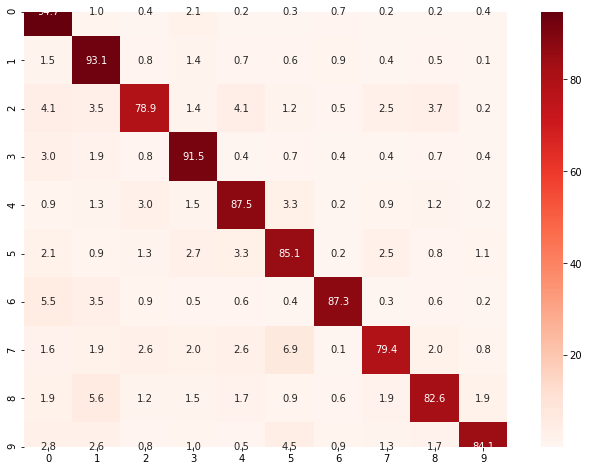

In [34]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=flat_array)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0
sns.heatmap(cm, annot=True, cmap='Reds', fmt='.1f', square=True);

In [35]:
def plotImages(images, rows, cols, cls_true, cls_pred=None):
    fig, axes = plt.subplots(rows, cols)
    rs = np.random.choice(images.shape[0], rows*cols)
    for i, j in zip(rs, axes.flat): 
        if cls_pred is None:
            title = "True: {0}".format(np.argmax(cls_true[i]))
        else:
            title = "True: {0}, Pred: {1}".format(np.argmax(cls_true[i]), cls_pred[i])  
     
        j.imshow(images[i,:,:,0], cmap='binary')
        j.set_title(title)
        j.set_xticks([])
        j.set_yticks([])

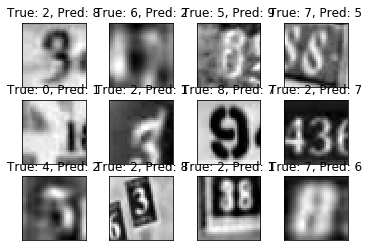

In [36]:
incorrect = flat_array != np.argmax(y_test, axis=1)
images = x_test[incorrect]
cls_true = y_test[incorrect]
cls_pred = flat_array[incorrect]

plotImages(images, 3, 4, cls_true, cls_pred);

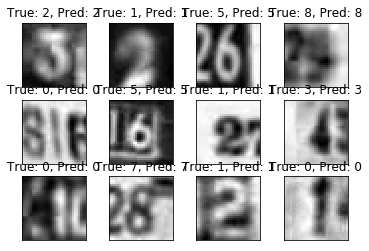

In [37]:
correct = np.invert(incorrect)
images = x_test[correct]
cls_true = y_test[correct]
cls_pred = flat_array[correct]
plotImages(images, 3, 4, cls_true, cls_pred);